<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

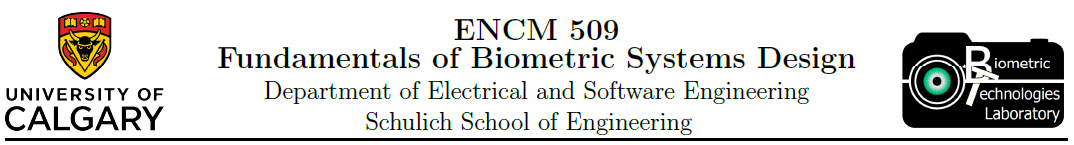

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part 2: Matching</h3>
    <h3>Talha Khalil, 30037871</h3>
</center>

# Introduction
The purpose of this lab is perform finger print matching as well as get a qualitative understanding of finger print matching parameters. Additonally learn how Minutiae and Gabor matching is peformed.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi


from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian, gabor_kernel

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.align2 import align2
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match
from utils.blockproc import blockproc

from matplotlib.patches import Rectangle
from utils.MatchGaborFeat import MatchGaborFeat

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')


In [4]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [5]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

In [6]:
def plot_and_create_garbor_filter(image, title,angle=-np.pi/4, frequency=0.11):
    fil = gabor_template(img, angle, frequency)
    filtered_image = gabor_filtering(image, fil)
    print(title)
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray'); plt.title('Original image')
    plt.subplot(1,3,2)
    plt.imshow(fil, cmap='gray'); plt.title('Filter used')
    plt.subplot(1,3,3)
    plt.imshow(filtered_image, cmap='gray'); plt.title('Image processed');


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART II: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file `Lab04Fingerprint2gab.ipynb` to perform the Gabor filtering on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

In [7]:
# Reading one of the fingerprints
img = imread('Fingerprints/Talha_Right_Thumb/0.bmp', as_gray=True)

Frequency 0.11 Angle -pi/4


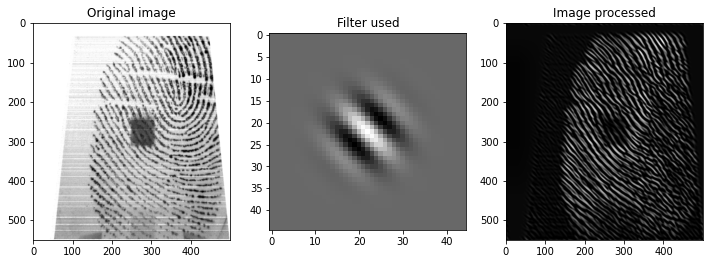

In [8]:
plot_and_create_garbor_filter(img, "Frequency 0.11 Angle -pi/4")

Frequency 0.22 Angle -pi/4


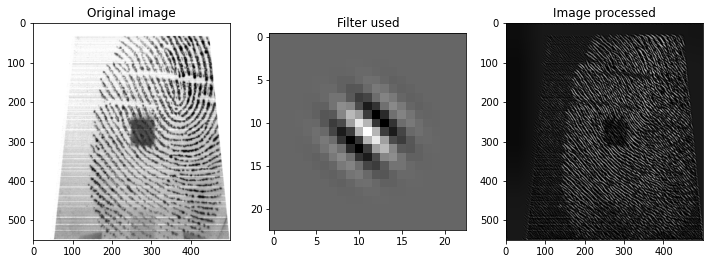

In [9]:
plot_and_create_garbor_filter(img, "Frequency 0.22 Angle -pi/4", frequency=0.22)

Frequency 0.05 Angle -pi/4


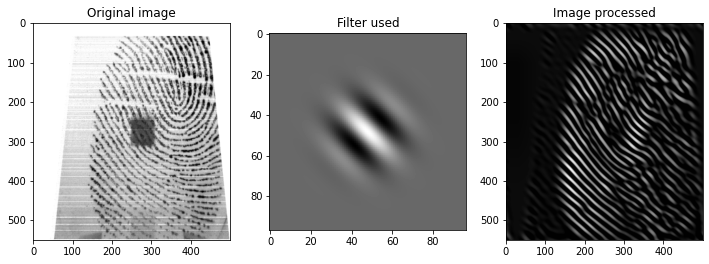

In [10]:
plot_and_create_garbor_filter(img, "Frequency 0.05 Angle -pi/4", frequency=0.05)

Frequency 0.11 Angle -pi


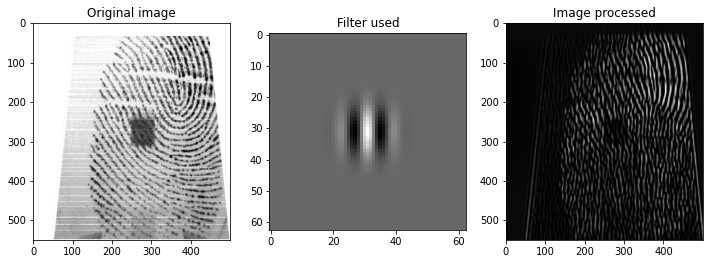

In [11]:
plot_and_create_garbor_filter(img, "Frequency 0.11 Angle -pi", angle=-np.pi)

Frequency 0.11 Angle -pi/2


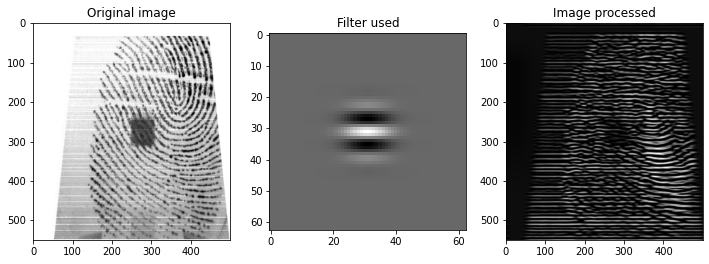

In [12]:
plot_and_create_garbor_filter(img, "Frequency 0.11 Angle -pi/2", angle=-np.pi/2)

Frequency 0.11 Angle -pi/3


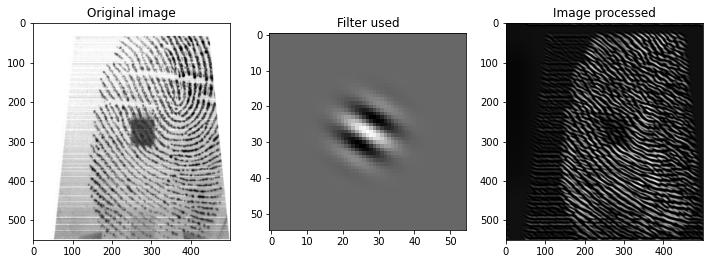

In [13]:
plot_and_create_garbor_filter(img, "Frequency 0.11 Angle -pi/3", angle=-np.pi/3)

## Analysis
Visually we can see that the effect of changing the frequency for the gabor filter results in a change in the percieved detail of the finger print. Increasing the frequency increases the level of detail where as decreasing the frequency decreases the level of percieved detail. The change in angle changes the direction in which the processed image seems to be constructed. Much like an effect of wind on grass.

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

In [14]:
finger_prints = [None]*10
processed_finger_prints = [None]*10
for x in range(10):
    finger_prints[x] = imread('Fingerprints/Talha_Right_Thumb/'+str(x)+'.bmp', as_gray=True)
    processed_finger_prints[x] = fingerprint_processing(finger_prints[x], block_size=12, threshold=0.1)

Total of minutiae detected: 853
Total of singularities detected: 4
Total of minutiae detected: 646
Total of singularities detected: 4
Total of minutiae detected: 538
Total of singularities detected: 6
Total of minutiae detected: 568
Total of singularities detected: 4
Total of minutiae detected: 436
Total of singularities detected: 4
Total of minutiae detected: 601
Total of singularities detected: 21
Total of minutiae detected: 424
Total of singularities detected: 0
Total of minutiae detected: 424
Total of singularities detected: 0
Total of minutiae detected: 607
Total of singularities detected: 16
Total of minutiae detected: 294
Total of singularities detected: 0


In [16]:
# Using FingerPrint 0 as probe.
for x in range(9):
    imSkeletonAlign, minutiaArrayAlign = align2(processed_finger_prints[0], processed_finger_prints[x+1])
    processed_finger_prints[x+1]['imSkeletonAlign'] = imSkeletonAlign
    processed_finger_prints[x+1]['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(processed_finger_prints[0], processed_finger_prints[x+1], threshold2=match_threshold)
    print('FP0 ' + 'vs FP ' + str(x+1) +' score for minutiae: %.4f\n' % (score))

number of matched minutiae: 309
distance total computed : 1364
number of minutiae in input image: 5051
number of minutiae in database image: 1039
FP0 vs FP 1 score for minutiae: 0.1015

number of matched minutiae: 403
distance total computed : 1871
number of minutiae in input image: 9048
number of minutiae in database image: 1039
FP0 vs FP 2 score for minutiae: 0.0799

number of matched minutiae: 223
distance total computed : 998
number of minutiae in input image: 4770
number of minutiae in database image: 1039
FP0 vs FP 3 score for minutiae: 0.0768

number of matched minutiae: 308
distance total computed : 1384
number of minutiae in input image: 4010
number of minutiae in database image: 1039
FP0 vs FP 4 score for minutiae: 0.1220

number of matched minutiae: 131
distance total computed : 591
number of minutiae in input image: 2961
number of minutiae in database image: 1039
FP0 vs FP 5 score for minutiae: 0.0655

number of matched minutiae: 0
distance total computed : 0
number of minu

## Analysis
| Finger Print ID      | Minutiae Finger Print Matching Score w\ Finger Print 0 |
| ----------- | ----------- |
| 1      |    0.1015    |
| 2   |  0.0799       |
| 3      |    0.0768    |
| 4   |   0.1220     |
| 5      |     0.0655  |
| 6   |       0.0000 |
| 7      |    0.0000    |
| 8   |     0.0656    |
| 9      |      0.0000  |

Using the scores above we can choose a threshold score of 0.0768 which results in a True Positive of 4/4, as index 1-4 are considered 'Good Fingerprints'. Using this threshold we also get False Negatives as 0/4 for the 'Bad fingerprints' indexed 5-9. Changing the treshold will change our TP and FN drastically if we made it stricter (aka moved the threshold up). Increasing it would cause our TP to fall and and our FN to increase.

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

In [ ]:
# Using FingerPrint 0 as probe.
for x in range(9):
    score = MatchGaborFeat(finger_prints[0], finger_prints[x+1], plot_res=False)
    print('FP0 ' + 'vs FP ' + str(x+1) +' score for gabor: %.4f\n' % (score))

FP0 vs FP 1 score for gabor: 0.0056

FP0 vs FP 2 score for gabor: 0.0050

FP0 vs FP 3 score for gabor: 0.0058

FP0 vs FP 4 score for gabor: 0.0057

FP0 vs FP 5 score for gabor: 0.0062

FP0 vs FP 6 score for gabor: 0.0062

FP0 vs FP 7 score for gabor: 0.0067

FP0 vs FP 8 score for gabor: 0.0056

FP0 vs FP 9 score for gabor: 0.0077



## Analysis
| Finger Print ID      | Gabor Filter Finger Print Matching Score w\ Finger Print 0 |
| ----------- | ----------- |
| 1      | 0.0056       |
| 2   | 0.0050 |
| 3      |    0.0058    |
| 4   |     0.0057   |
| 5      |   0.0062   |
| 6   |    0.0062   |
| 7      |   0.0067   |
| 8   |     0.0056  |
| 9      |    0.0077  |

Because we know that for a gabor filter a lower score indicates a better match, using the above scores we can set a threshold of 0.0058, where if the score matches this or is lower, then we have a good match. Using this we can count the number of true matches as 4/4, where index 1-4 is 'good finger print'. And we also have 0 False negatives. However we do have 1 False Positive, using Index 5-9 as 'bad fingerprints' where there was one fingerprint with a low enough score that it matched our threshold. We could bring the threshold even lower however that would then decrease the amount of TP and increase the amount of FN. If we wanted stricter security we could make this change. One of the things we can note from the gabor filter so far is that the scores seems to be much 'tighter' than that of minutiae matching.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.

In [ ]:
# Fingerprint 0 is still probe, index 0
# Fingerprint 1 is used as same individual template, index 1
# Shelby's Fingerprints are used as separate indivudal, index 2 - 11
ex4_finger_prints = [None]*12
ex4_processed_finger_prints = [None]*12

ex4_finger_prints[0] = finger_prints[0]
ex4_finger_prints[1] = finger_prints[1]

ex4_processed_finger_prints[0] = processed_finger_prints[0]
ex4_processed_finger_prints[1] = processed_finger_prints[1]

for x in range(10):
    ex4_finger_prints[x+2] = imread('Fingerprints/Shelby_Right_Thumb/'+str(x)+'.bmp', as_gray=True)
    ex4_processed_finger_prints[x+2] = fingerprint_processing(ex4_finger_prints[x+2], block_size=12, threshold=0.1)

In [ ]:
# Using FingerPrint 0 as probe.
for x in range(11):
    imSkeletonAlign, minutiaArrayAlign = align2(ex4_processed_finger_prints[0], ex4_processed_finger_prints[x+1])
    ex4_processed_finger_prints[x+1]['imSkeletonAlign'] = imSkeletonAlign
    ex4_processed_finger_prints[x+1]['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(ex4_processed_finger_prints[0], ex4_processed_finger_prints[x+1], threshold2=match_threshold)
    print('FP0 ' + 'vs FP ' + str(x+1) +' score for minutiae: %.4f\n' % (score))

number of matched minutiae: 309
distance total computed : 1364
number of minutiae in input image: 5051
number of minutiae in database image: 1039
FP0 vs FP 1 score for minutiae: 0.1015

number of matched minutiae: 297
distance total computed : 1312
number of minutiae in input image: 5512
number of minutiae in database image: 1039
FP0 vs FP 2 score for minutiae: 0.0907

number of matched minutiae: 408
distance total computed : 1943
number of minutiae in input image: 10371
number of minutiae in database image: 1039
FP0 vs FP 3 score for minutiae: 0.0715

number of matched minutiae: 285
distance total computed : 1279
number of minutiae in input image: 4174
number of minutiae in database image: 1039
FP0 vs FP 4 score for minutiae: 0.1093

number of matched minutiae: 467
distance total computed : 2049
number of minutiae in input image: 7400
number of minutiae in database image: 1039
FP0 vs FP 5 score for minutiae: 0.1107

number of matched minutiae: 406
distance total computed : 1796
number

## Analysis
| Finger Print ID      | Finger Print Matching Score w\ Finger Print Talha 0 | RANK |
| ----------- | ----------- | ----------- |
| Talha 1    | 0.1015        |5|
| Shelby 0   | 0.0907        |7|
| Shelby 1   | 0.0715        |8|
| Shelby 2   | 0.1093        |3|
| Shelby 3   | 0.1107        |2|
| Shelby 4   | 0.1042        |4|
| Shelby 5   | 0.0664        |9|
| Shelby 6   | 0.0921        |6|
| Shelby 7   | 0.0544        |11|
| Shelby 8   | 0.1165        |1|
| Shelby 9   | 0.0650        |10|

Our true match 'Talha 1' is not ranked the highest but rather as number 5. Based on this we know there are 4/10 False Positives, and 6/10 True Negatives. Based of these errors we can conclude that threshold choice is not good as there is a high False positive rate as well as a small true negative rate.

# Conclusion
From these experiments we can conclude that the Minutiae matching is much more rigrious and produces a wider spread of scores than that of the gabor filter. However, even then the matching using the minutiae filter for this lab was not great when compared to another individuals finger prints, where the False Positive Rate was high and there was also a small true negative rate. This could be because the 'prints' were not of great quality, or because of the parameters chosen. A better method going forward might be to instead to have many fingerprint templates to match with and then aggregate scores based on the scoring recieved from all references. This would show a truer score of whether a print matches or not. As it has been shown that a single image grab of a fingerprint is not enough to differentiate it from others.